In [183]:
#importing libraries
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random

In [192]:
#load the data
filepath = 'chat.txt'
df_final = None
with open(filepath, 'r', encoding='utf-8') as f:
    df = pd.DataFrame(f.read().splitlines(), columns=['text'])
print(df)

                                                    text
0      [12/1/24, 7:40:43 PM] Rides Denton to anywhere...
1      [12/5/24, 3:33:39 PM] ~ Sukhemeen Kaur: ‎Waiti...
2      [12/6/24, 8:33:03 AM] ~ Guide My Class💯🎶: ‎‎~ ...
3      [12/6/24, 6:23:34 PM] ~ Teju 💫: ‎~ Teju 💫 join...
4      [12/6/24, 10:29:30 PM] ~ Johannas katikala: ‎W...
...                                                  ...
38379  [5/2/25, 4:20:44 PM] ~ Prudvi: Needi ride Irvi...
38380  [5/2/25, 4:21:57 PM] ~ Shaik Sohail: Need ride...
38381  [5/2/25, 4:25:25 PM] ~ Swamy Vaka _7$: Need ri...
38382  [5/2/25, 4:25:29 PM] ~ Swamy Vaka _7$: Need ri...
38383  [5/2/25, 4:26:48 PM] ~ ‎Nn: Need ride from Lew...

[38384 rows x 1 columns]


In [208]:
#Processing Data

df[['timestamp', 'message']] = df['text'].str.extract(r'^\[(.*?)\]\s(?:~?\s?[^:]+:\s)?(.*)')
df.dropna(subset=['timestamp', 'message'], inplace=True)
df['timestamp'] = df['timestamp'].str.replace('\u202f', ' ')
print(df['timestamp'])

508      3/20/25, 6:35:36 AM
509      3/20/25, 7:25:16 AM
511      3/20/25, 8:30:13 AM
513      3/20/25, 8:43:53 AM
515      3/20/25, 9:15:42 AM
                ...         
38377     5/2/25, 4:20:17 PM
38380     5/2/25, 4:21:57 PM
38381     5/2/25, 4:25:25 PM
38382     5/2/25, 4:25:29 PM
38383     5/2/25, 4:26:48 PM
Name: timestamp, Length: 19127, dtype: object


In [210]:
#type of request
df['type_of_req'] = np.select([                                            
    df['message'].str.contains(r"\bneed ride\b", case=False, na=False),
    df['message'].str.contains(r"\bride available\b", case=False, na=False)
], ['Request', 'Offer'], default=None)
df.dropna(subset=['type_of_req'], inplace=True)

#splitting the timestamp column to 2 columns
dt_series = pd.to_datetime(df['timestamp'], format='%m/%d/%y, %I:%M:%S %p', errors='coerce')
df['date_req'] = dt_series.dt.strftime('%Y-%m-%d')
df['time_req'] = dt_series.dt.strftime('%H:%M:%S')
df.dropna(subset=['date_req', 'time_req'], inplace=True)
print(df['date_req'], df['time_req'])

508      2025-03-20
509      2025-03-20
511      2025-03-20
513      2025-03-20
515      2025-03-20
            ...    
38377    2025-05-02
38380    2025-05-02
38381    2025-05-02
38382    2025-05-02
38383    2025-05-02
Name: date_req, Length: 19127, dtype: object 508      06:35:36
509      07:25:16
511      08:30:13
513      08:43:53
515      09:15:42
           ...   
38377    16:20:17
38380    16:21:57
38381    16:25:25
38382    16:25:29
38383    16:26:48
Name: time_req, Length: 19127, dtype: object


In [185]:
#to convert the time to 24hr format.
def standardize_time_to_24hr(time_str):
    if pd.isna(time_str): return None
    ts = str(time_str).strip().lower()
    
    if ts in ('asap', 'anytime'):
        return (datetime.now() + timedelta(minutes=random.randint(0, 1439))).strftime('%H:%M')
    if 'morning' in ts: return '09:00'
    if 'afternoon' in ts: return '15:00'
    if 'evening' in ts: return '19:00'
    if 'tonight' in ts: return '21:00'
    if ts == 'noon': return '12:00'
    if ts == 'midnight': return '00:00'
    if match := re.match(r'^(\d{1,2}:\d{2}):\d{2}$', ts):
        return match.group(1)
    if range_match := re.match(r'^(\d{1,2}(?:[:.]\d{2})?)\s*(?:-|to)\s*\d{1,2}(?:[:.]\d{2})?(\s*(?:am|pm))?', ts):
        part, ampm = range_match.group(1), range_match.group(2) or ''
        for fmt in [part + ampm, '1970-01-01 ' + part + ampm]:
            try: return pd.to_datetime(fmt).strftime('%H:%M')
            except: continue

    for fmt in [ts, '1970-01-01 ' + ts]:
        try: return pd.to_datetime(fmt).strftime('%H:%M')
        except: continue
    return None

In [206]:

time_pattern = r"(?i)(?:at|around|by|between|before|after|on|anytime)?\s*(\d{1,2}(?::\d{2})?\s*(?:am|pm)?(?:\s*(?:-|to)\s*\d{1,2}(?::\d{2})?\s*(?:am|pm)?)?|asap|anytime|tonight|morning|afternoon|evening|noon|midnight|now)"
df['time_needed_raw'] = df['message'].str.extract(time_pattern)[0].str.strip().str.lower()
df.loc[df['time_needed_raw'] == 'now', 'time_needed_raw'] = df['time_req']
df['time_needed_24hr'] = df['time_needed_raw'].apply(standardize_time_to_24hr)

# Extract Locations
loc_pattern = r'(?i)(?:\bfrom\s+([\w\s.-]+?)\s+to\s+([\w\s.-]+)\b|\bto\s+([\w\s.-]+)\s+from\s+([\w\s.-]+)\b)'
extracted = df['message'].str.extract(loc_pattern)
df['from_place'] = extracted[0].combine_first(extracted[3])
df['to_place'] = extracted[1].combine_first(extracted[2])

def clean_place(place):
    if pd.isna(place): return None
    place = place.lower().strip()
    if place.startswith('dent'): return 'Denton'
    return re.sub(r'^[^\w]+|[^\w]+$', '', re.sub(r'\s*(at|on|around|near|,|\.|will pay|need|asap|now|available|tonight|today|tomorrow|\b(?:am|pm|oclock|o\'clock)\b).*$', '', place)).title()

df['from_place'] = df['from_place'].apply(clean_place)
df['to_place'] = df['to_place'].apply(clean_place)

# Final
df_final = df[['date_req', 'time_req', 'type_of_req', 'from_place', 'to_place', 'time_needed_24hr']].copy()
df_final.dropna(inplace=True)  # <--- Drop rows with any NaN values
print(df_final.head(10))




       date_req  time_req type_of_req      from_place         to_place  \
508  2025-03-20  06:35:36       Offer          Austin  Irving Thursday   
509  2025-03-20  07:25:16     Request  Farmers Branch         Richards   
511  2025-03-20  08:30:13       Offer          Denton      Harri Hines   
513  2025-03-20  08:43:53     Request          Denton           Irving   
515  2025-03-20  09:15:42     Request          Denton      Flowermound   
516  2025-03-20  09:23:52     Request          Denton           Dallas   
517  2025-03-20  09:24:32     Request          Denton          Coppell   
521  2025-03-20  10:04:04     Request          Denton         Richards   
522  2025-03-20  10:09:08     Request          Denton       Little Elm   
530  2025-03-20  10:16:01     Request       Grapevine           Denton   

    time_needed_24hr  
508            03:00  
509            10:00  
511            10:00  
513            09:30  
515            09:15  
516            12:00  
517            10:00  
5

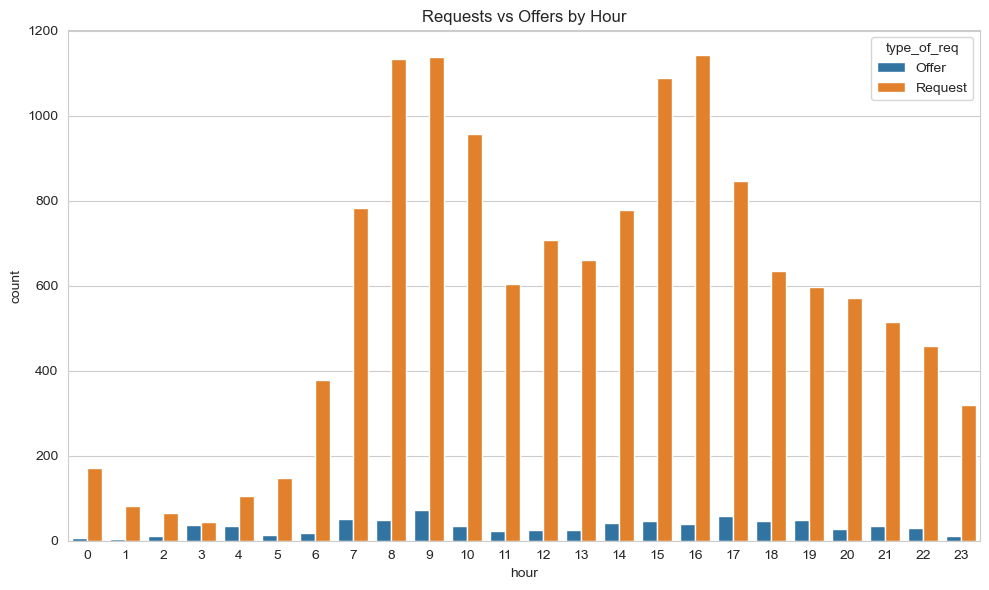

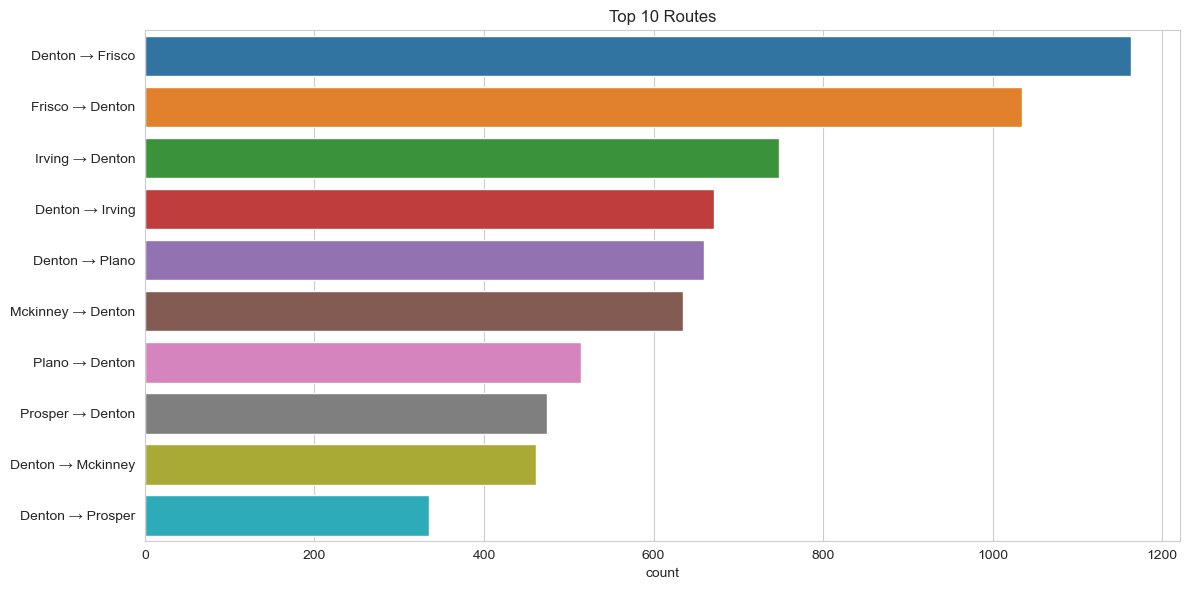

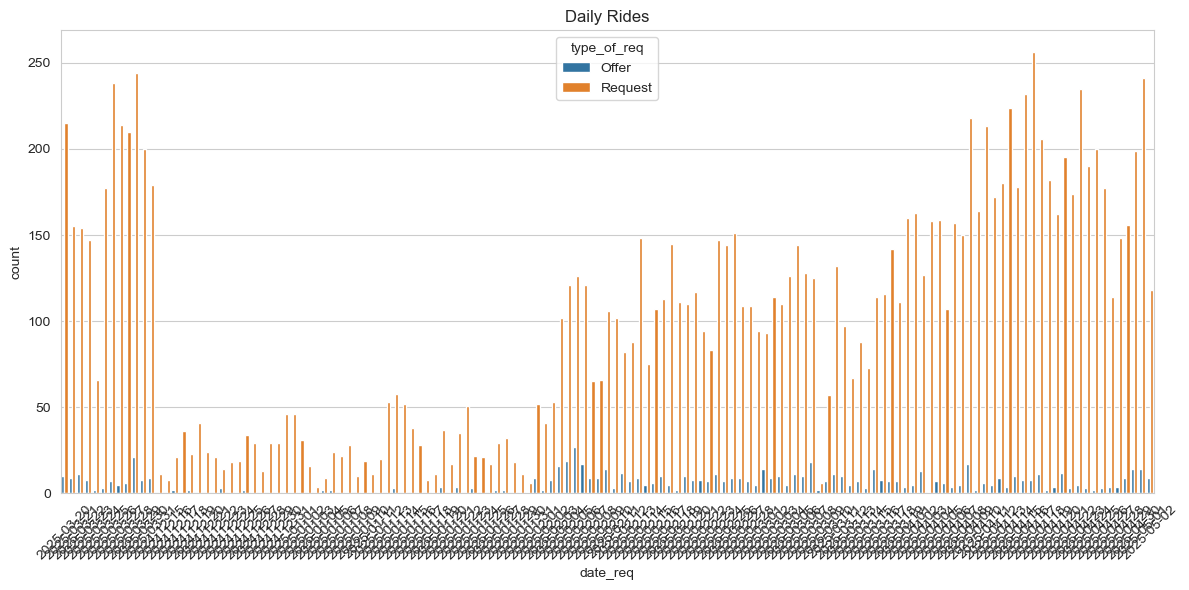

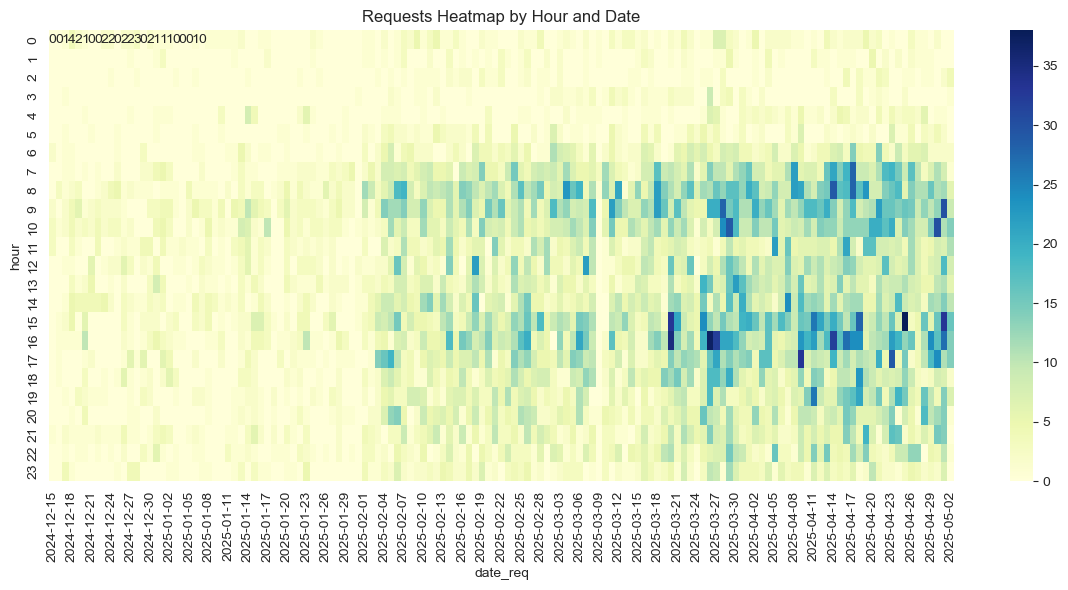

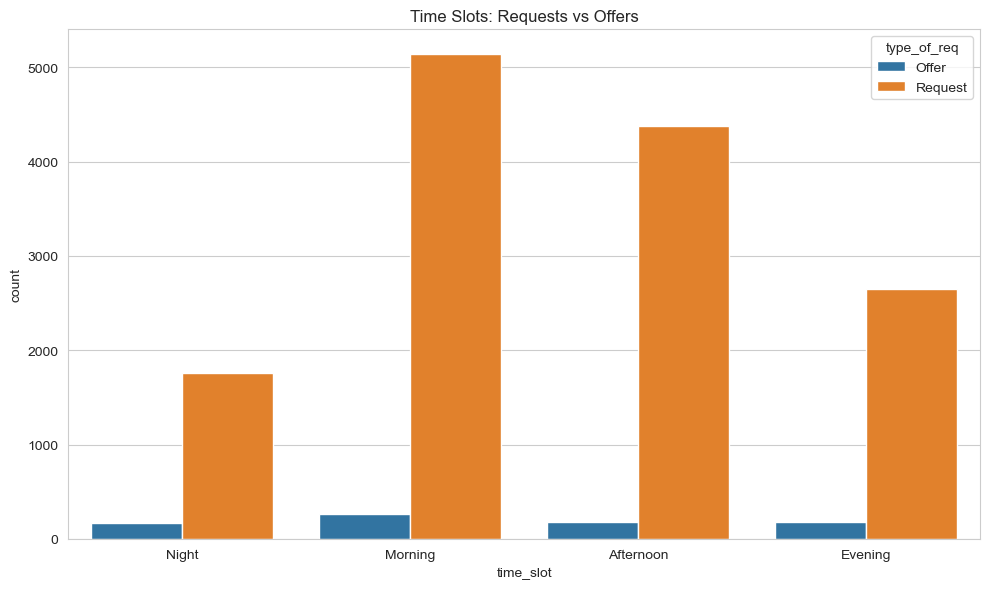

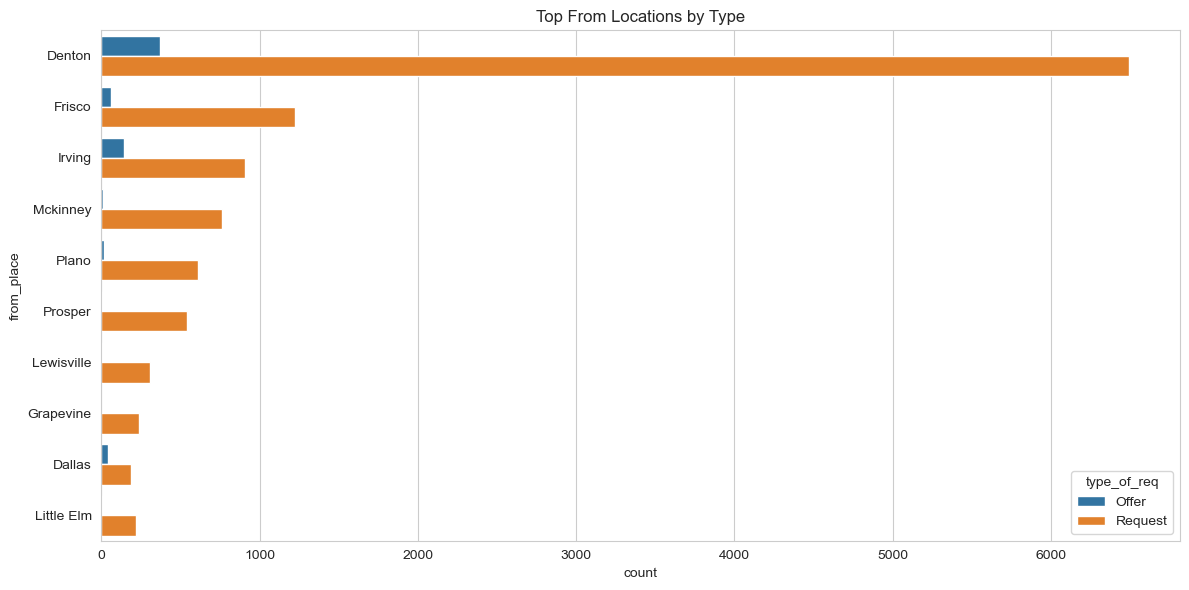

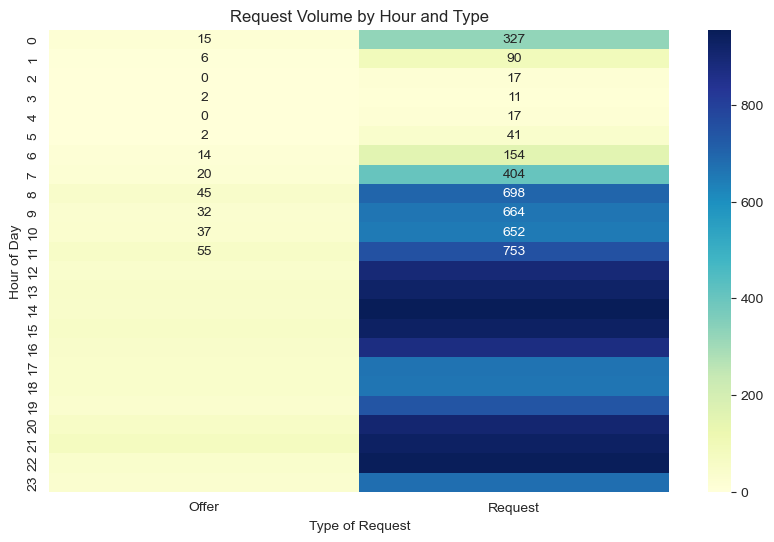

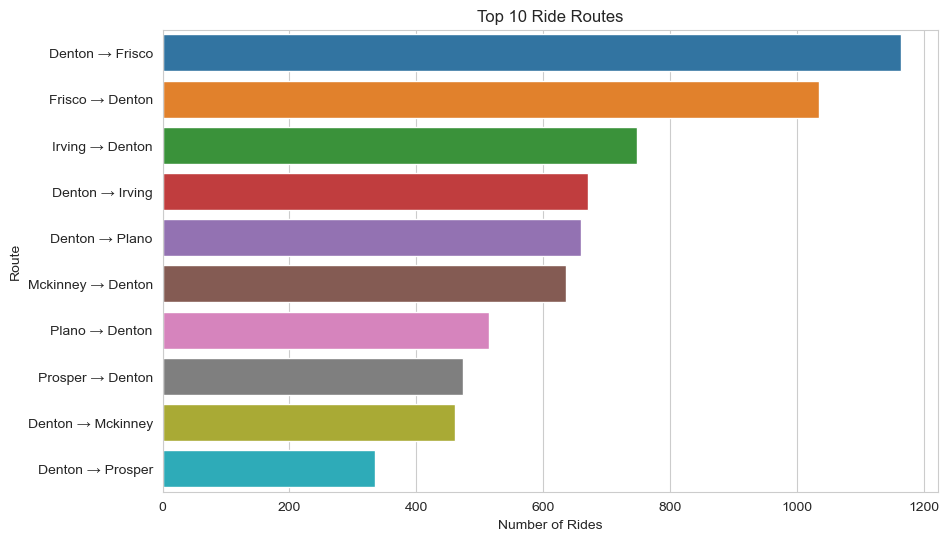

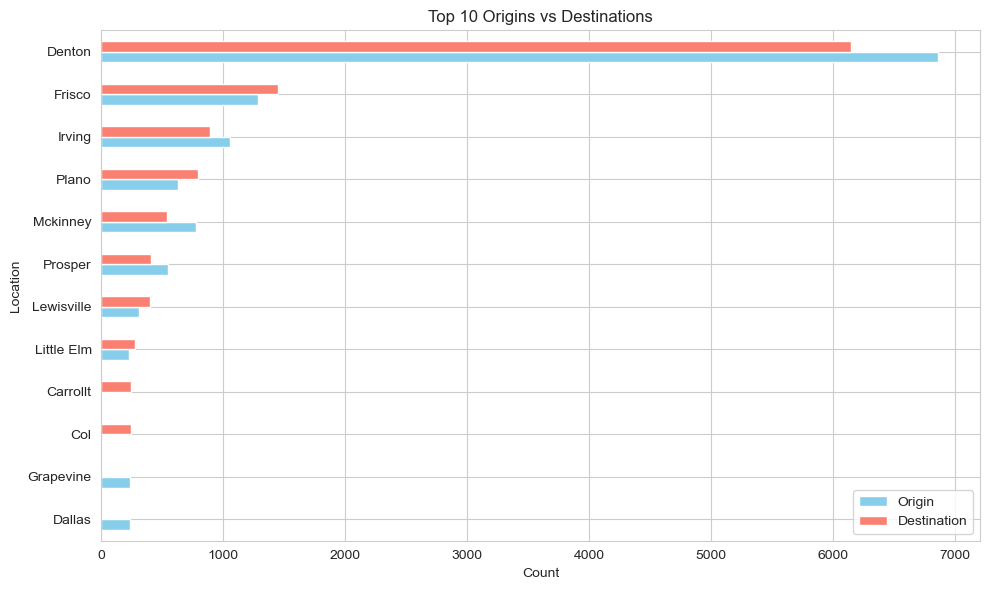

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


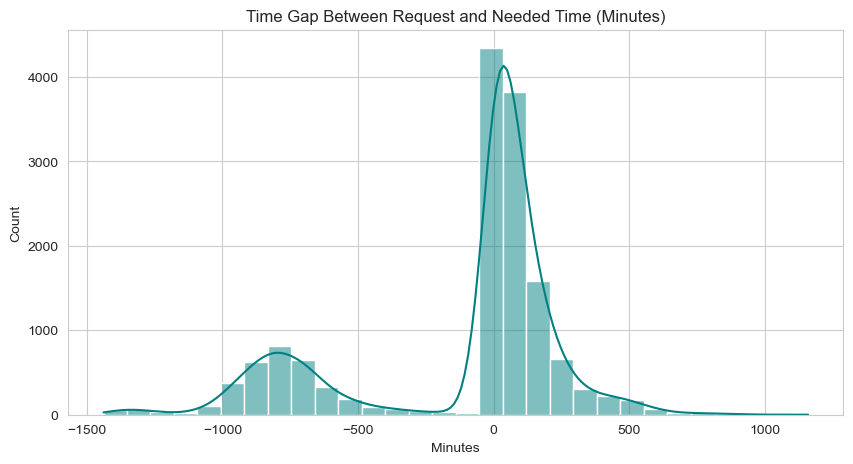

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


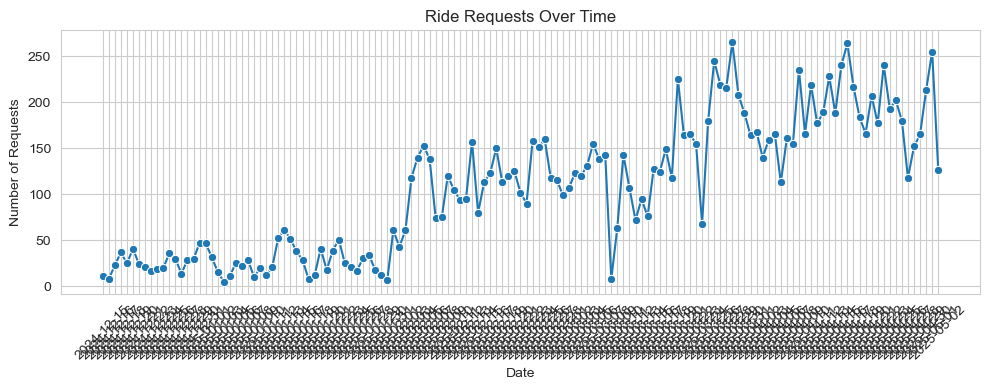

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


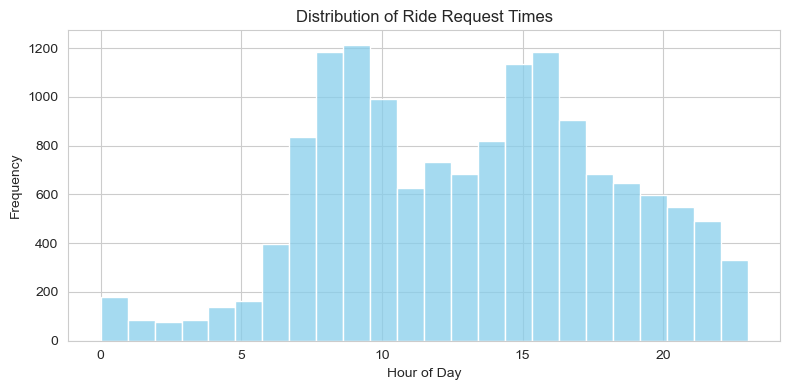

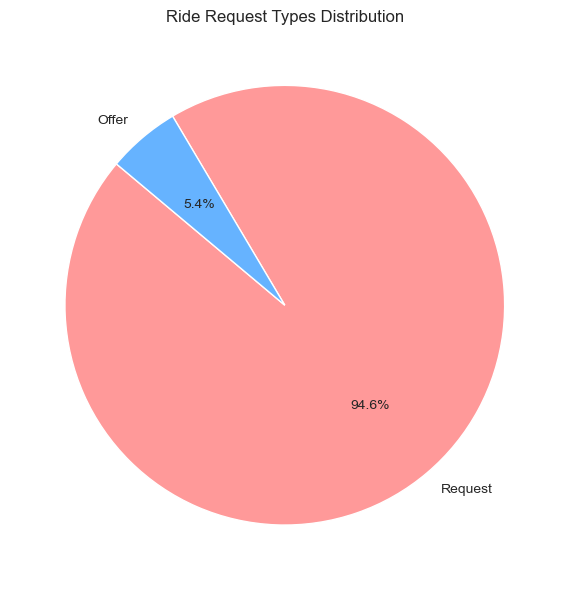

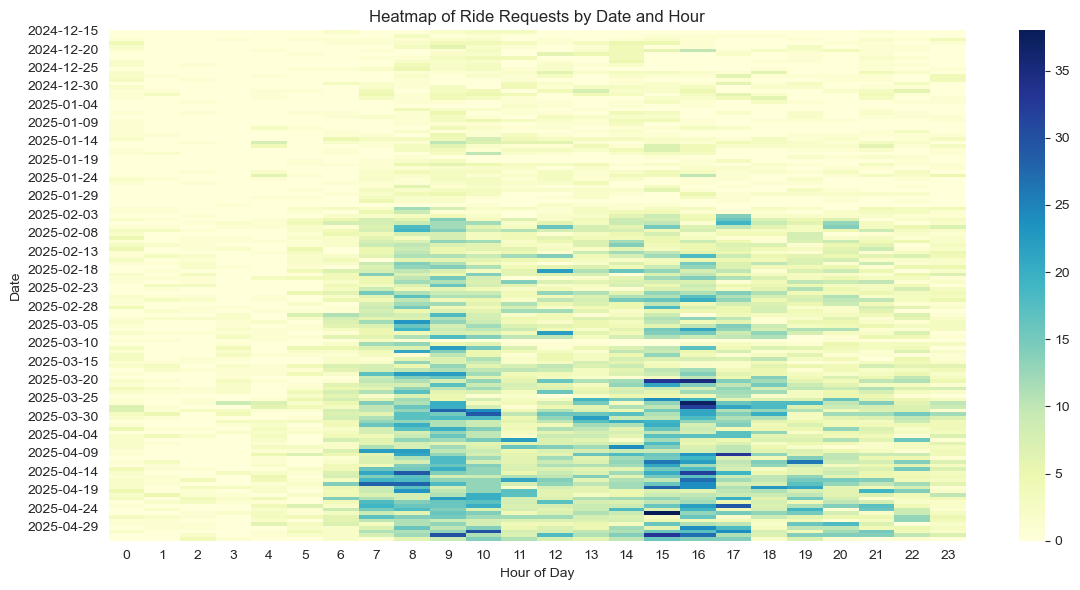

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


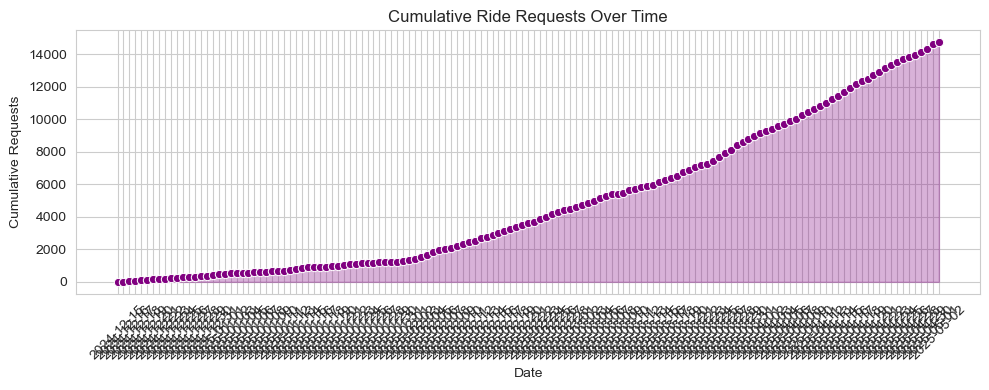

In [244]:
#Visualization


df_final['hour'] = pd.to_datetime(df_final['time_needed_24hr'], format='%H:%M', errors='coerce').dt.hour
df_final['time_slot'] = df_final['hour'].apply(
    lambda h: 'Morning' if 5 <= h < 12 else 'Afternoon' if 12 <= h < 17 else 'Evening' if 17 <= h < 21 else 'Night'
    if pd.notna(h) else 'Unknown'
)

# 1. Requests vs Offers by Hour
plt.figure(figsize=(10, 6))
sns.countplot(data=df_final, x='hour', hue='type_of_req')
plt.title('Requests vs Offers by Hour')
plt.tight_layout()
plt.show()

# 2. Top Routes
top_routes = df_final.groupby(['from_place', 'to_place']).size().reset_index(name='count')
top_routes = top_routes.sort_values(by='count', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_routes, x='count', y=top_routes['from_place'] + ' → ' + top_routes['to_place'])
plt.title('Top 10 Routes')
plt.tight_layout()
plt.show()

# 3. Daily Ride Volume
plt.figure(figsize=(12, 6))
sns.countplot(data=df_final, x='date_req', hue='type_of_req')
plt.title('Daily Rides')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Hourly Heatmap
heatmap_data = df_final.groupby(['date_req', 'hour']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data.T, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Requests Heatmap by Hour and Date')
plt.tight_layout()
plt.show()

# 5. Time Slot by Request Type
plt.figure(figsize=(10, 6))
sns.countplot(data=df_final, x='time_slot', hue='type_of_req')
plt.title('Time Slots: Requests vs Offers')
plt.tight_layout()
plt.show()

# 6. From Locations vs Type
plt.figure(figsize=(12, 6))
sns.countplot(data=df_final, y='from_place', hue='type_of_req',
              order=df_final['from_place'].value_counts().head(10).index)
plt.title('Top From Locations by Type')
plt.tight_layout()
plt.show()


# Convert time columns to datetime.time
df_final['time_req_dt'] = pd.to_datetime(df_final['time_req'], format='%H:%M:%S', errors='coerce').dt.time
df_final['time_needed_dt'] = pd.to_datetime(df_final['time_needed_24hr'], format='%H:%M', errors='coerce').dt.time

# 7. Heatmap: Hour vs Type of Request
df_final['req_hour'] = pd.to_datetime(df_final['time_req'], format='%H:%M:%S', errors='coerce').dt.hour
heat_data = pd.crosstab(df_final['req_hour'], df_final['type_of_req'])
plt.figure(figsize=(10, 6))
sns.heatmap(heat_data, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Request Volume by Hour and Type')
plt.xlabel('Type of Request')
plt.ylabel('Hour of Day')
plt.show()

# 8. Sankey-style Ride Flow (as bar pairs)
route_counts = df_final.groupby(['from_place', 'to_place']).size().reset_index(name='count')
top_routes = route_counts.sort_values(by='count', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(data=top_routes, x='count', y=top_routes['from_place'] + ' → ' + top_routes['to_place'])
plt.title('Top 10 Ride Routes')
plt.xlabel('Number of Rides')
plt.ylabel('Route')
plt.show()


#9. Top 10 origin and destination counts
top_from = df_final['from_place'].value_counts().head(10)
top_to = df_final['to_place'].value_counts().head(10)
combined = pd.DataFrame({
    'Origin': top_from,
    'Destination': top_to
}).fillna(0)
combined['max'] = combined[['Origin', 'Destination']].max(axis=1)
combined = combined.sort_values(by='max', ascending=True)
combined.drop('max', axis=1, inplace=True)
combined.plot(kind='barh', figsize=(10, 6), color=['skyblue', 'salmon'])
plt.title('Top 10 Origins vs Destinations')
plt.xlabel('Count')
plt.ylabel('Location')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# 10. Time Difference Between Request and Needed Time
df_final['time_req_min'] = pd.to_datetime(df_final['time_req'], format='%H:%M:%S', errors='coerce').dt.hour * 60 + pd.to_datetime(df_final['time_req'], format='%H:%M:%S', errors='coerce').dt.minute
df_final['time_needed_min'] = pd.to_datetime(df_final['time_needed_24hr'], format='%H:%M', errors='coerce').dt.hour * 60 + pd.to_datetime(df_final['time_needed_24hr'], format='%H:%M', errors='coerce').dt.minute
df_final['time_diff_min'] = df_final['time_needed_min'] - df_final['time_req_min']
df_final = df_final[df_final['time_diff_min'].notna()]
plt.figure(figsize=(10, 5))
sns.histplot(df_final['time_diff_min'], bins=30, kde=True, color='teal')
plt.title('Time Gap Between Request and Needed Time (Minutes)')
plt.xlabel('Minutes')
plt.show()





# 11. Line Chart of Requests Over Time
df_line = df_final.groupby('date_req').size().reset_index(name='count')
plt.figure(figsize=(10,4))
sns.lineplot(data=df_line, x='date_req', y='count', marker='o')
plt.title('Ride Requests Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Requests')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 12. Histogram of Distribution of Request Times
plt.figure(figsize=(8,4))
sns.histplot(df_final['hour'].dropna(), bins=24, kde=False, color='skyblue')
plt.title('Distribution of Ride Request Times')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


# 13. Pie Chart of Request Type Proportion
request_counts = df_final['type_of_req'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(request_counts, labels=request_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('Ride Request Types Distribution')
plt.tight_layout()
plt.show()



# 14. Heatmap of Requests by Hour and Date
df_heatmap = df_final.groupby(['date_req', 'hour']).size().unstack(fill_value=0)
plt.figure(figsize=(12,6))
sns.heatmap(df_heatmap, cmap='YlGnBu')
plt.title('Heatmap of Ride Requests by Date and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Date')
plt.tight_layout()
plt.show()

# 15. Area Chart of Cumulative Requests Over Time
df_area = df_final.groupby('date_req').size().cumsum().reset_index(name='cumulative_requests')
plt.figure(figsize=(10,4))
sns.lineplot(data=df_area, x='date_req', y='cumulative_requests', marker='o', color='purple')
plt.fill_between(df_area['date_req'], df_area['cumulative_requests'], color='purple', alpha=0.3)
plt.title('Cumulative Ride Requests Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Requests')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



